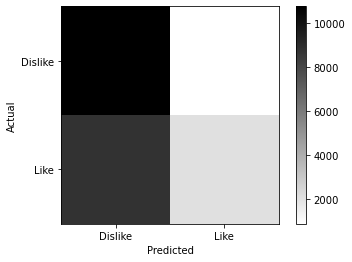

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))', expand=False)
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)', expand=False)
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

ratings_df.drop('timestamp', axis=1, inplace=True)

movie_ratings_df = pd.merge(movies_df, ratings_df, on='movieId')

ratings_pivot = movie_ratings_df.pivot_table(index=['userId'], columns=['title'], values='rating')
ratings_pivot.fillna(0, inplace=True)
ratings_matrix = np.array(ratings_pivot)

genres = movies_df['genres'].str.split('|')
genres = genres.apply(pd.Series).stack().reset_index(drop=True)
genres = pd.DataFrame({'genre': genres})
genres_onehot = pd.get_dummies(genres, columns=['genre'])
genre_matrix = genres_onehot.groupby(level=0).sum().values
content_sim = cosine_similarity(genre_matrix)

train, test = train_test_split(ratings_matrix, test_size=0.2)

user_similarity = cosine_similarity(train)
mean_user_rating = train.mean(axis=1)
ratings_diff = (train - mean_user_rating[:, np.newaxis])
user_pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

X_train = []
y_train = []

for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        if train[i, j] > 0:
            X_train.append([user_pred[i, j], content_sim[j].mean()])
            y_train.append(1 if train[i, j] >= 4 else 0)

X_test = []
y_test = []

for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        if test[i, j] > 0:
            X_test.append([user_pred[i, j], content_sim[j].mean()])
            y_test.append(1 if test[i, j] >= 4 else 0)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, cmap='binary', interpolation='None')
plt.colorbar()
plt.xticks([0, 1], ['Dislike', 'Like'])
plt.yticks([0, 1], ['Dislike', 'Like'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()